# imports

In [114]:
! nvidia-smi

Mon May 30 13:57:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:1A:00.0 Off |                  Off |
| 30%   29C    P8    15W / 300W |  11735MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install -q transformers kaggle apex

You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5ForConditionalGeneration, T5TokenizerFast

from tqdm.auto import tqdm
import gc

%matplotlib inline

# config

In [1]:
class Config:

    model_name = "google/t5-v1_1-base"
    tokenizer_name = "t5-base"

    src_max_tokens = 768
    tgt_max_tokens = 256

    t_data_frac = 0.15
    v_data_frac = 0.2

    batch_size = 16
    num_workers = 2
    lr = 5e-4
    wd = 1e-2

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# fetch dataset from kaggle

we're using the [CNN-DailyMail](https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail) dataset for abstractive summarization.

In [7]:
! rm -rf ~/.kaggle && mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download -d gowrishankarp/newspaper-text-summarization-cnn-dailymail
! unzip newspaper-text-summarization-cnn-dailymail.zip

 99%|███████████████████████████████████████▌| 498M/503M [00:24<00:00, 20.1MB/s]
100%|████████████████████████████████████████| 503M/503M [00:24<00:00, 21.8MB/s]
Archive:  newspaper-text-summarization-cnn-dailymail.zip
  inflating: cnn_dailymail/test.csv  
  inflating: cnn_dailymail/train.csv  
  inflating: cnn_dailymail/validation.csv  


# create dataset

while `train.csv` contains ~280k entries, we're only going to be using 5% of them for starters. Same for val and test.

In [47]:
df_train = pd.read_csv('cnn_dailymail/train.csv')
df_val = pd.read_csv('cnn_dailymail/validation.csv')

# sample [Config.data_frac]% of data
df_train = df_train.sample(n=int(Config.t_data_frac * len(df_train)))
df_val = df_val.sample(n=int(Config.v_data_frac * len(df_val)))

df_train.columns, df_train.shape, df_val.shape

(Index(['id', 'article', 'highlights'], dtype='object'),
 (43066, 3),
 (2673, 3),
 (2298, 3))

In [88]:
class CNNDailyMailDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        data = self.df.iloc[idx] # id article highlights

        data.article = 'summarize: ' + data.article
        src_tokens = self.tokenizer(data.article, return_tensors='pt',
                                    padding='max_length', truncation=True,
                                    max_length = Config.src_max_tokens)
        
        tgt_tokens = self.tokenizer(data.highlights, return_tensors='pt',
                                    padding='max_length', truncation=True,
                                    max_length = Config.tgt_max_tokens)

        # by convention, labels for ignored tokens (so just padding) should be set to -100
        tgt_tokens.input_ids[tgt_tokens.input_ids == self.tokenizer.pad_token_id] = -100

        # flatten is i guess a thing with T5? don't need it with other models
        return (src_tokens.input_ids.flatten(), src_tokens.attention_mask.flatten(),
                tgt_tokens.input_ids.flatten(), tgt_tokens.attention_mask.flatten())

# training i guess

In [50]:
def train_epoch(model, dl, opt):
    model.to(device)
    model.train()

    total_loss = 0
    losses = []
    for (input_ids, attention_mask, labels, decoder_attention_mask) in tqdm(dl):
        # set data to same device as model
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        decoder_attention_mask = decoder_attention_mask.to(device)

        # run model
        loss = model(input_ids, attention_mask=attention_mask, labels=labels, decoder_attention_mask=decoder_attention_mask).loss
        total_loss += loss.item()
        losses.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()  # optional TODO: try a triangular scheduler? if needed

    torch.cuda.empty_cache()
    gc.collect()

    return total_loss / len(dl), losses

In [51]:
def validate(model, dl):
    model.to(device)
    model.eval()

    total_loss = 0
    for (input_ids, attention_mask, labels, decoder_attention_mask) in tqdm(dl):
        # set data to same device as model
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        decoder_attention_mask = decoder_attention_mask.to(device)

        # run model
        with torch.no_grad():
            loss = model(input_ids, attention_mask=attention_mask, labels=labels, decoder_attention_mask=decoder_attention_mask).loss
            total_loss += loss.item()

    torch.cuda.empty_cache()
    gc.collect()

    return total_loss / len(dl)

In [52]:
def train(model, df_train, df_val, opt, tknzr, epochs=5, name='unnamed_model'):
    ds_train = CNNDailyMailDataset(df_train, tknzr)
    ds_val = CNNDailyMailDataset(df_val, tknzr)
    dl_train = DataLoader(ds_train, batch_size=Config.batch_size, shuffle=True, num_workers=Config.num_workers)
    dl_val = DataLoader(ds_val, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)

    best_v_loss = float('inf')
    t_losses = []  # list of all train losses by batch; for visualization
    v_losses = []  # list of all avg validation losses by epoch;
    for i in range(epochs):
        print(f'\nEpoch {i}:')
        t_loss, batch_losses = train_epoch(model, dl_train, opt)
        v_loss = validate(model, dl_val)
        print(f'\tTrain loss: {t_loss:.3f}')
        print(f'\tValidation loss: {v_loss:.3f}')
        t_losses.extend(batch_losses)
        v_losses.append(v_loss)

        if v_loss < best_v_loss:
            best_v_loss = v_loss
            loss_str = str(round(v_loss, 3)).replace('.', '_')
            torch.save(model.state_dict(), f'{name}-e{i}-l{loss_str}.ckpt')

    return t_losses, v_losses

# setting up model

we freeze embeddings for much faster training

In [54]:
t5_model = T5ForConditionalGeneration.from_pretrained(Config.model_name)
t5_model.config.use_cache = False  # no idea why is it True by default, not needed
t5_model.config.max_length = Config.tgt_max_tokens  # needs to be set for inference

t5_model.shared.weight.requires_grad = False

tokenizer = T5TokenizerFast.from_pretrained(Config.tokenizer_name)

In [55]:
optimizer = torch.optim.AdamW(t5_model.parameters(), lr=Config.lr, weight_decay=Config.wd, eps=1e-6)

t_losses, v_losses = train(t5_model, df_train, df_val, optimizer, tokenizer, epochs=5, name='t5_v11_base')

def plot_losses(t_losses, v_losses):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.suptitle('Horizontally stacked subplots')
  ax1.plot(range(len(t_losses)), t_losses)
  ax2.plot(range(len(v_losses)), v_losses, 'orange')

plot_losses(t_losses, v_losses)

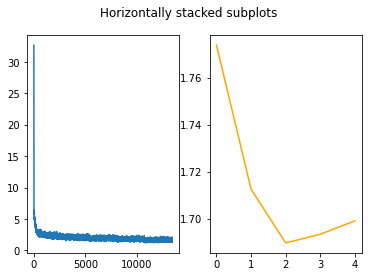

In [111]:
plot_losses(t_losses, v_losses)

In [69]:
torch.save(t5_model.state_dict(), f't5_v11_base-overfit-l1_699.ckpt')

# inference i guess

In [89]:
def inference(model, df_inf, tknzr):
    ds_inf = CNNDailyMailDataset(df_inf, tknzr)
    dl_inf = DataLoader(ds_inf, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)

    model.to(device)
    model.eval()
    
    summary_list = []
    for (input_ids, attention_mask, _, _) in tqdm(dl_inf):
        # set data to same device as model
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        # run model
        with torch.no_grad():
            out = model.generate(input_ids, attention_mask=attention_mask,
                               do_sample=True, 
                               top_k=50, 
                               top_p=0.95
                              )
        summaries = tokenizer.batch_decode(out, skip_special_tokens=True)
        summary_list.extend(summaries)

    torch.cuda.empty_cache()
    gc.collect()

    df_generated = df_inf.copy()
    df_generated['generated'] = summary_list
    return df_generated

In [115]:
df_generated = inference(t5_model, df_test[:100], tokenizer)

  0%|          | 0/7 [00:00<?, ?it/s]

# example

In [116]:
example = df_generated.iloc[42]

In [117]:
example.article

"The world endurance championship, whose annual highlight is the Le Mans 24 Hours sportscar classic, is getting rid of the grid girls. In a move that will be applauded by many, and is sure to dismay those accustomed to seeing scantily-clad beauties posing next to cars before a race, the FIA-backed series is adopting a more progressive stance. 'From Silverstone next week, you will see that for any race we will do - no grid girls like in the past,' WEC chief executive Gerard Neveu said after a presentation on Thursday for the opening Silverstone six-hour race. The world endurance championship have announced that there will be no more 'grid girls' before races . The decision by the FIA is seen as a progressive one by those in a male-dominated sport . 'For me that is the past. The condition of women is a little bit different now,' he said. The use of models, also referred to as 'race queens' or 'umbrella girls', to stand by cars with flags or placards displaying drivers' numbers has long b

In [118]:
example.generated

"The world endurance championship is changing stance on grid girls. Instead of having girls race in the past it has come to their favour. Formula One racers are referred to as 'race queens' or 'umbrella girls' to stand next to cars with flags and placards on the grid."

In [119]:
example.highlights

"World endurance championship begins at Silverstone on April 12 .\nScantily-clad beauties traditionally pose next to cars before races .\n'Grid girls' decision\xa0has been welcomed for those seeking gender equality ."